In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%%writefile gpu_usage.sh

end=$((SECONDS+10))

while [ $SECONDS -lt $end ]; do
    nvidia-smi --format=csv --query-gpu=power.draw,utilization.gpu,memory.used,memory.free,fan.speed,temperature.gpu >> gpu.log
    
done




Writing gpu_usage.sh


In [ ]:
%%bash --bg

bash gpu_usage.sh

In [ ]:
!nvidia-smi

Thu Apr 27 01:34:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |    373MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## installations libraries
!pip install IPython
!pip install ipyplot
!pip install rasterio 
!pip install torch
!pip install --upgrade Pillow 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 60.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [ ]:
## importing libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os
from io import BytesIO
import PIL
from IPython.display import display, Image
import ipyplot
import os.path
from os import path
from PIL import Image
import numpy as np 
import glob

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
# from torchvision import datasets, models
# import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

import tifffile as tiff
import itertools

import rasterio
from rasterio.plot import show

from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf


from keras.models import load_model

 


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
## unzips the EuroSAT.zip dataset shared in the drive and creates a new drive and stores unzipped images
## in that
source_file = "/content/EuroSAT.zip"
!mkdir "/content/EuroSAT_Extracted"
dest_file = "/content/EuroSAT_Extracted"

import zipfile

zip_ref = zipfile.ZipFile(source_file, "r")
zip_ref.extractall(dest_file)
zip_ref.close()

In [ ]:
## unzips the LandSAT.zip dataset shared in the drive and creates a new drive and stores unzipped images
## in that
source_file = "/content/LandSAT.zip"
!mkdir "/content/LandSAT_Extracted"
dest_file = "/content/LandSAT_Extracted"

import zipfile

zip_ref = zipfile.ZipFile(source_file, "r")
zip_ref.extractall(dest_file)
zip_ref.close()

In [ ]:
# creating a Testing directory
path = "/content/TestDataset/gridimages/imagesOP"
isExist = os.path.exists(path)
if not isExist:

    os.makedirs(path)
    print("The new directory is created!")

The new directory is created!


In [ ]:
## crops one of the LandSAT images and stores the tiles in imagesOP folder as Testing data


def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = cv2.imread(os.path.join(dir_in, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = PIL.Image.fromarray(img)
    w, h = im_pil.size

    grid = itertools.product(range(0, h - h % d, d), range(0, w - w % d, d))
    for i, j in grid:
        box = (j, i, j + d, i + d)
        out = os.path.join(dir_out, f"{name}_{i}_{j}.PNG")
        im_pil.crop(box).save(out, quality=95)


tile(
    "city_003_color.TIFF",
    "/content/LandSAT_Extracted/LandSAT/lompoc",
    "/content/TestDataset/gridimages/imagesOP",
    64,
)

Found 27000 files belonging to 10 classes.


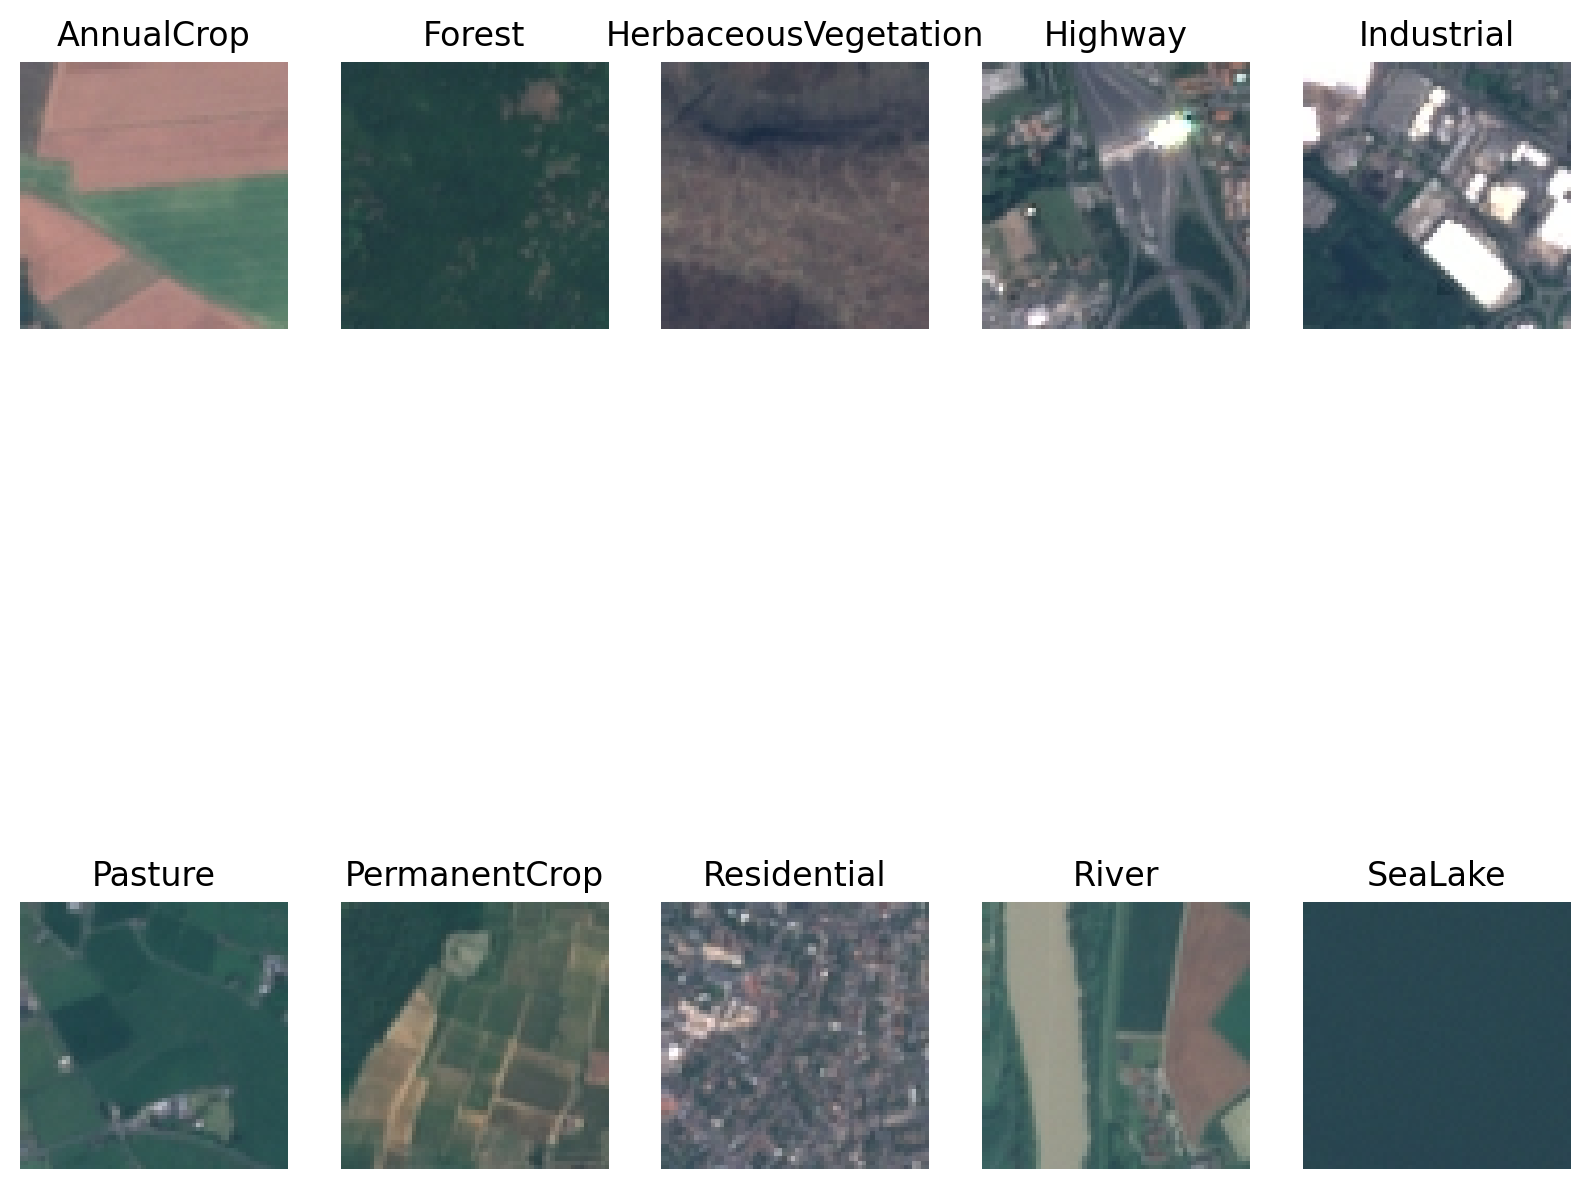

In [ ]:
## plotting some training images

trainingdata = image_dataset_from_directory(
    "/content/EuroSAT_Extracted/EuroSAT", batch_size=64, image_size=(64, 64)
)
classnames = trainingdata.class_names
plt.figure(figsize=(10, 10))
for i in range(len(classnames)):
    filtered_ds = trainingdata.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.title(classnames[label.numpy()[0]])
        plt.axis("off")

plt.show()

In [ ]:
# creating the training, test and validation sets

data_directory = "/content/EuroSAT_Extracted/EuroSAT"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    label_mode="categorical",
    batch_size=64
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    label_mode="categorical",
    batch_size=64
    )


test_ds = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(64, 64),
    shuffle=True,
    seed=123, 
    validation_split=None
)

 

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Found 27000 files belonging to 10 classes.


In [ ]:
# printing shape of training and validation sets
for image_batch, labels_batch in train_ds:
    print("Shape of Training Dataset:", image_batch.shape)
    print("Shape of Validation Dataset:", labels_batch.shape)
    break

Shape of Training Dataset: (64, 64, 64, 3)
Shape of Validation Dataset: (64, 10)


In [ ]:
##creating a neural network model

In [ ]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = DenseNet121(weights="imagenet", include_top=False) 

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with softmax activation for classification
predictions = Dense(10, activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Nadam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer = optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# model's summary
model.summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690719 to fit



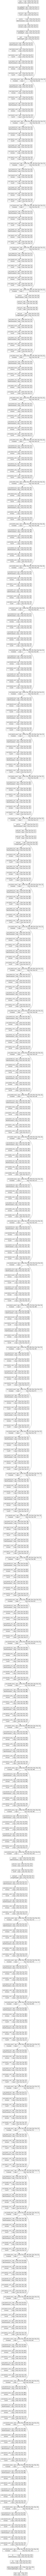

In [ ]:
from tensorflow.keras.utils import plot_model
from PIL import Image

plot_model(model, to_file='densent121_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('densent121_model.png'))

In [ ]:
## fitting the model and training it with train dataset and epochs 20 - gives increase after 15 
with tf.device('/device:GPU:0'):
  model.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=64)

Epoch 1/20
338/338 [==============================] - 34s 50ms/step - loss: 1.7080 - accuracy: 0.6869 - val_loss: 0.9882 - val_accuracy: 0.7650
Epoch 2/20
338/338 [==============================] - 12s 35ms/step - loss: 0.7705 - accuracy: 0.8004 - val_loss: 0.7290 - val_accuracy: 0.8146
Epoch 3/20
338/338 [==============================] - 11s 33ms/step - loss: 0.6159 - accuracy: 0.8289 - val_loss: 0.6608 - val_accuracy: 0.8215
Epoch 4/20
338/338 [==============================] - 12s 35ms/step - loss: 0.5227 - accuracy: 0.8458 - val_loss: 0.6921 - val_accuracy: 0.8174
Epoch 5/20
338/338 [==============================] - 12s 36ms/step - loss: 0.4916 - accuracy: 0.8507 - val_loss: 0.6224 - val_accuracy: 0.8337
Epoch 6/20
338/338 [==============================] - 11s 33ms/step - loss: 0.4421 - accuracy: 0.8638 - val_loss: 0.5246 - val_accuracy: 0.8502
Epoch 7/20
338/338 [==============================] - 13s 39ms/step - loss: 0.4263 - accuracy: 0.8688 - val_loss: 0.5479 - val_accuracy:

In [ ]:
!nvidia-smi

Wed Apr 26 21:31:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   1319MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

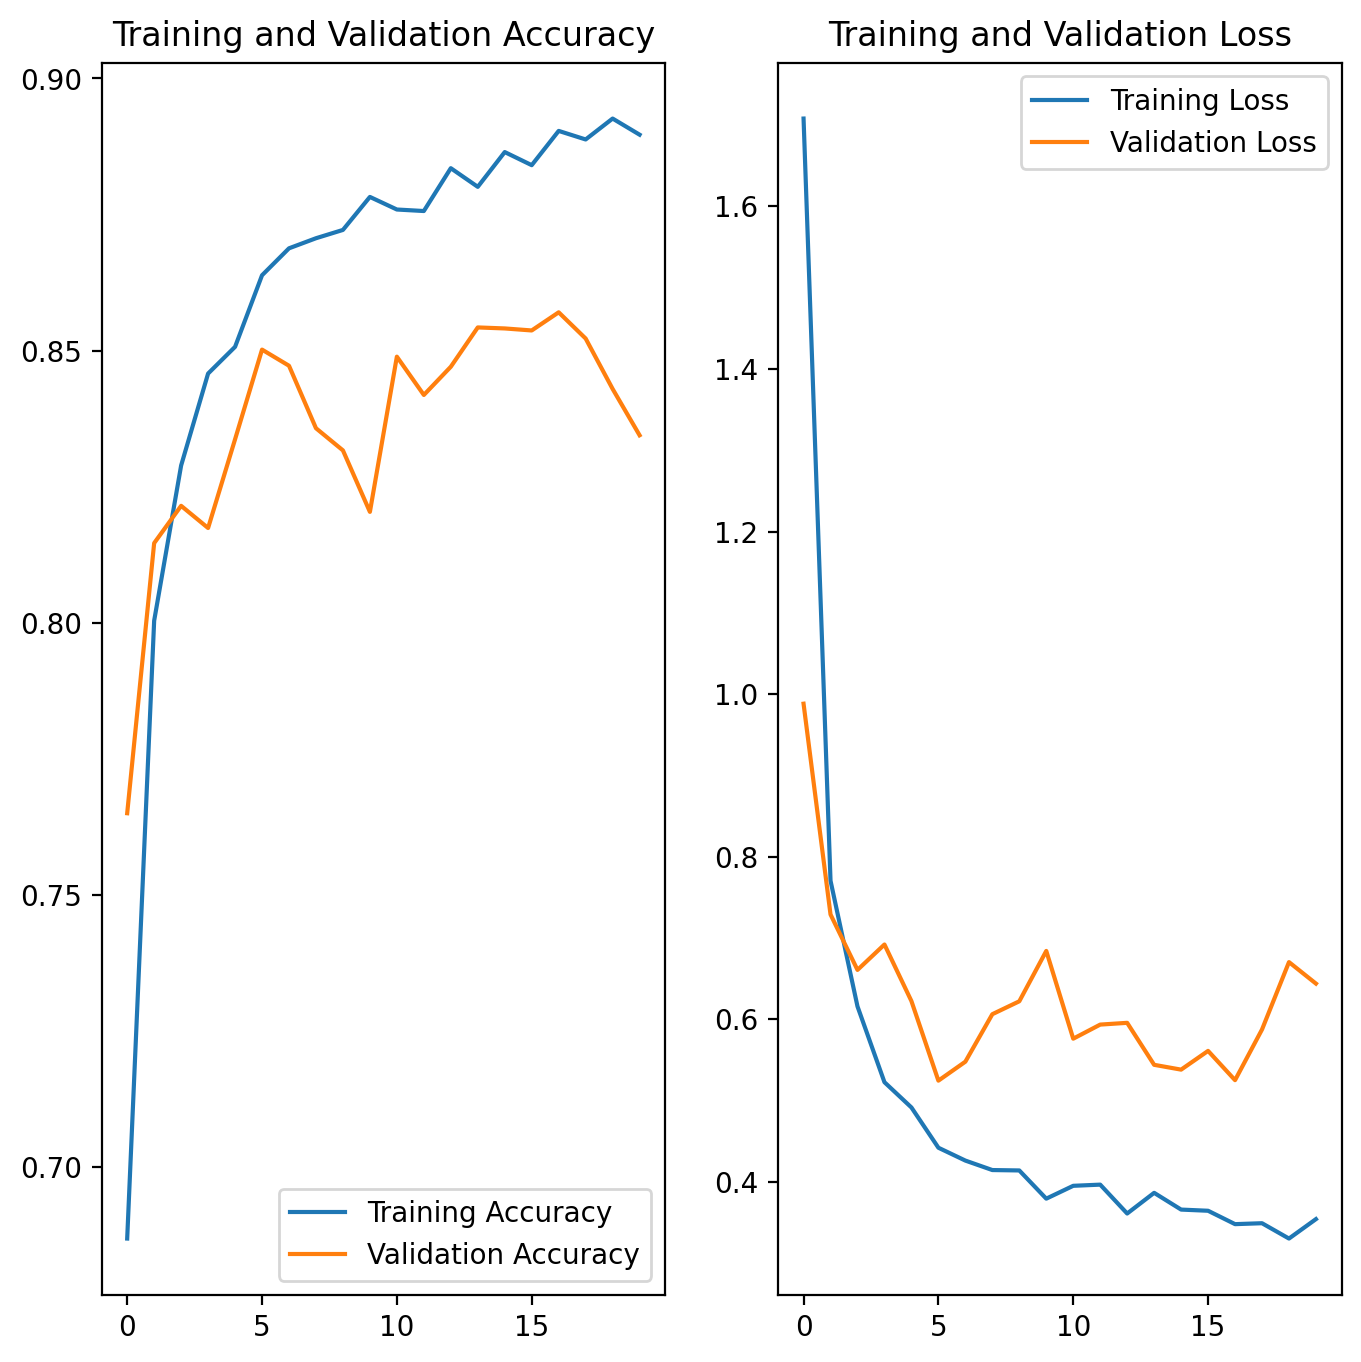

In [ ]:
# plotting the training and validation accuracy and loss

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, model.history.history["accuracy"], label="Training Accuracy")
plt.plot(
    epochs_range, model.history.history["val_accuracy"], label="Validation Accuracy"
)
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, model.history.history["loss"], label="Training Loss")
plt.plot(epochs_range, model.history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
## training with an altered epoch 15 epochs
with tf.device('/device:GPU:0'):
  model.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=64)

Epoch 1/15
338/338 [==============================] - 20s 38ms/step - loss: 1.6934 - accuracy: 0.6888 - val_loss: 0.9294 - val_accuracy: 0.7741
Epoch 2/15
338/338 [==============================] - 11s 33ms/step - loss: 0.7439 - accuracy: 0.8105 - val_loss: 0.7651 - val_accuracy: 0.8100
Epoch 3/15
338/338 [==============================] - 13s 37ms/step - loss: 0.6013 - accuracy: 0.8326 - val_loss: 0.6757 - val_accuracy: 0.8226
Epoch 4/15
338/338 [==============================] - 11s 33ms/step - loss: 0.5234 - accuracy: 0.8472 - val_loss: 0.6605 - val_accuracy: 0.8241
Epoch 5/15
338/338 [==============================] - 11s 33ms/step - loss: 0.4855 - accuracy: 0.8549 - val_loss: 0.6338 - val_accuracy: 0.8280
Epoch 6/15
338/338 [==============================] - 11s 32ms/step - loss: 0.4522 - accuracy: 0.8610 - val_loss: 0.5778 - val_accuracy: 0.8369
Epoch 7/15
338/338 [==============================] - 11s 31ms/step - loss: 0.4168 - accuracy: 0.8692 - val_loss: 0.5959 - val_accuracy:

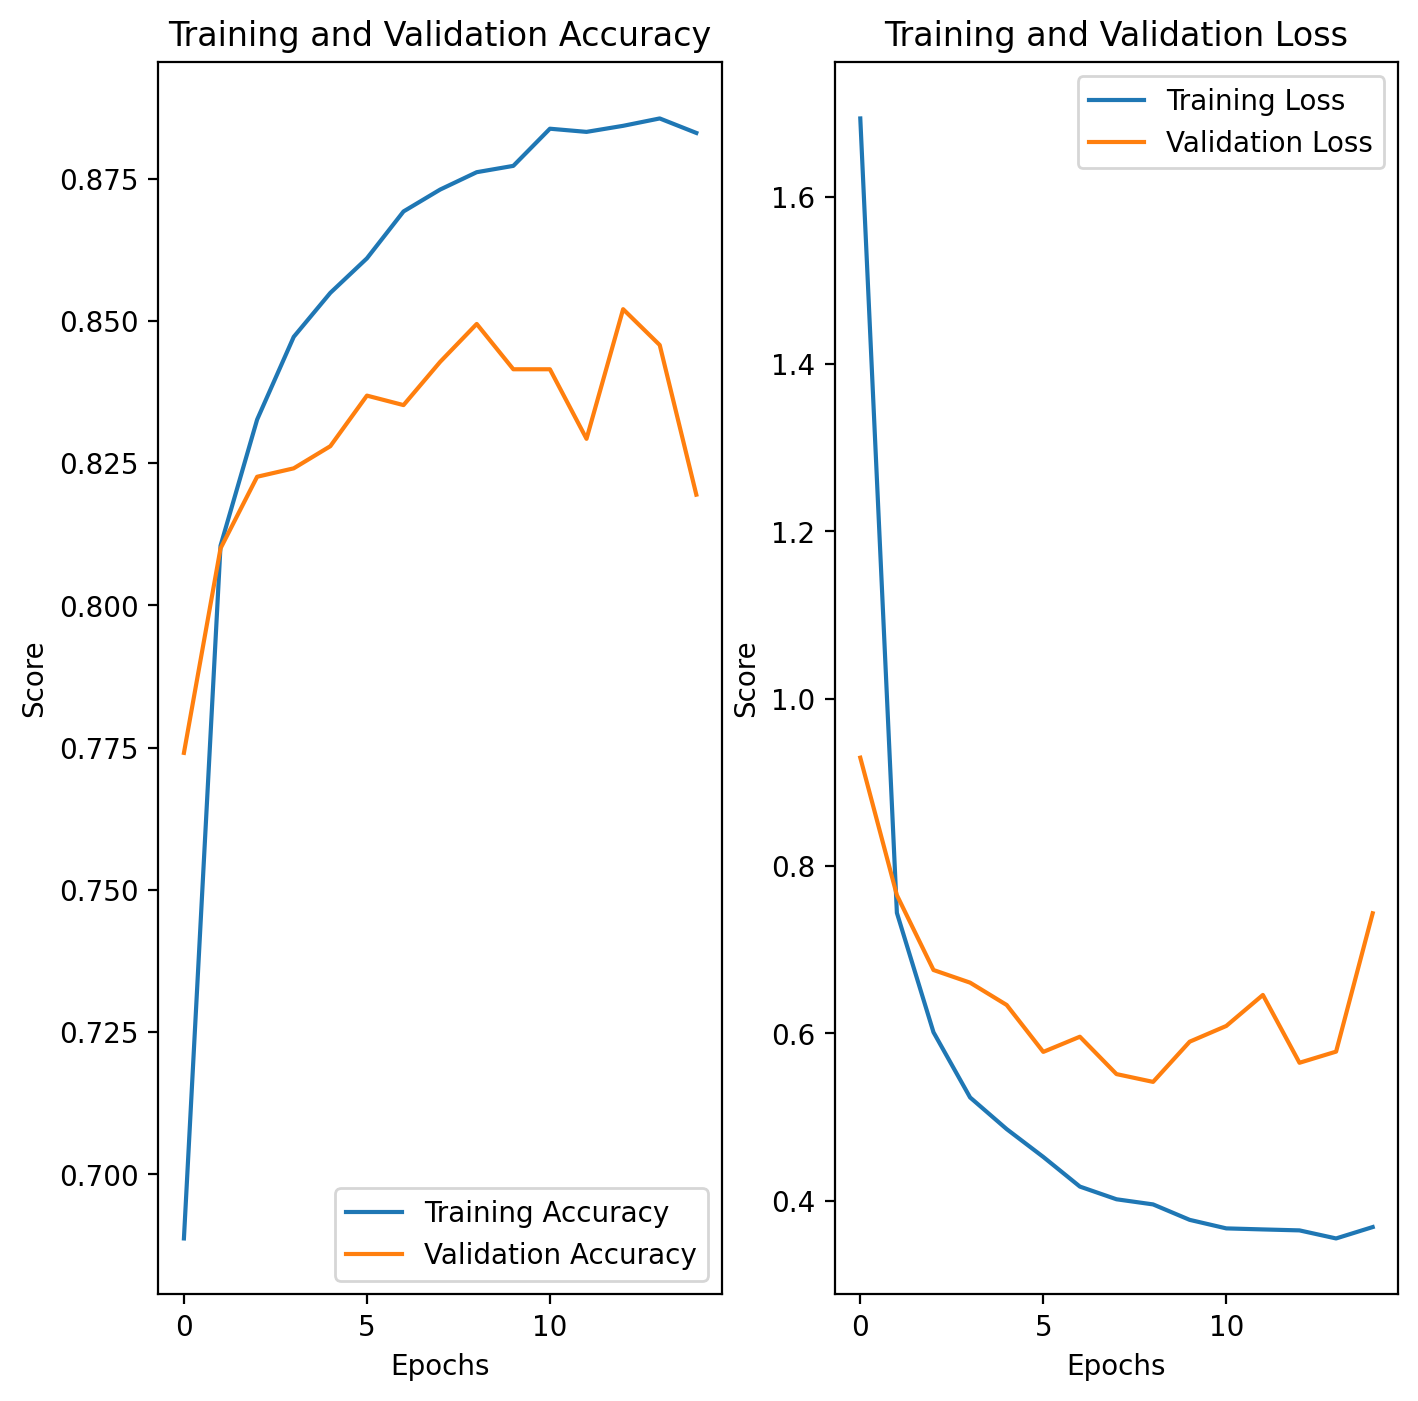

In [ ]:
# plotting the training and validation accuracy and loss

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, model.history.history["accuracy"], label="Training Accuracy")
plt.plot(
    epochs_range, model.history.history["val_accuracy"], label="Validation Accuracy"
)
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, model.history.history["loss"], label="Training Loss")
plt.plot(epochs_range, model.history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Loss")
plt.show()


In [ ]:
## fitting the model and training it with train dataset with 10 epochs and NADAM optimizer

with tf.device('/device:GPU:0'):
  model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=64)

Epoch 1/10
338/338 [==============================] - 23s 44ms/step - loss: 4.8626 - accuracy: 0.3557 - val_loss: 2.3302 - val_accuracy: 0.5589
Epoch 2/10
338/338 [==============================] - 13s 37ms/step - loss: 1.8468 - accuracy: 0.6180 - val_loss: 1.6379 - val_accuracy: 0.6591
Epoch 3/10
338/338 [==============================] - 13s 37ms/step - loss: 1.3824 - accuracy: 0.6873 - val_loss: 1.3392 - val_accuracy: 0.7067
Epoch 4/10
338/338 [==============================] - 13s 38ms/step - loss: 1.1471 - accuracy: 0.7259 - val_loss: 1.1749 - val_accuracy: 0.7300
Epoch 5/10
338/338 [==============================] - 13s 37ms/step - loss: 1.0006 - accuracy: 0.7519 - val_loss: 1.0603 - val_accuracy: 0.7481
Epoch 6/10
338/338 [==============================] - 13s 37ms/step - loss: 0.8952 - accuracy: 0.7689 - val_loss: 0.9712 - val_accuracy: 0.7624
Epoch 7/10
338/338 [==============================] - 13s 38ms/step - loss: 0.8160 - accuracy: 0.7837 - val_loss: 0.9107 - val_accuracy:

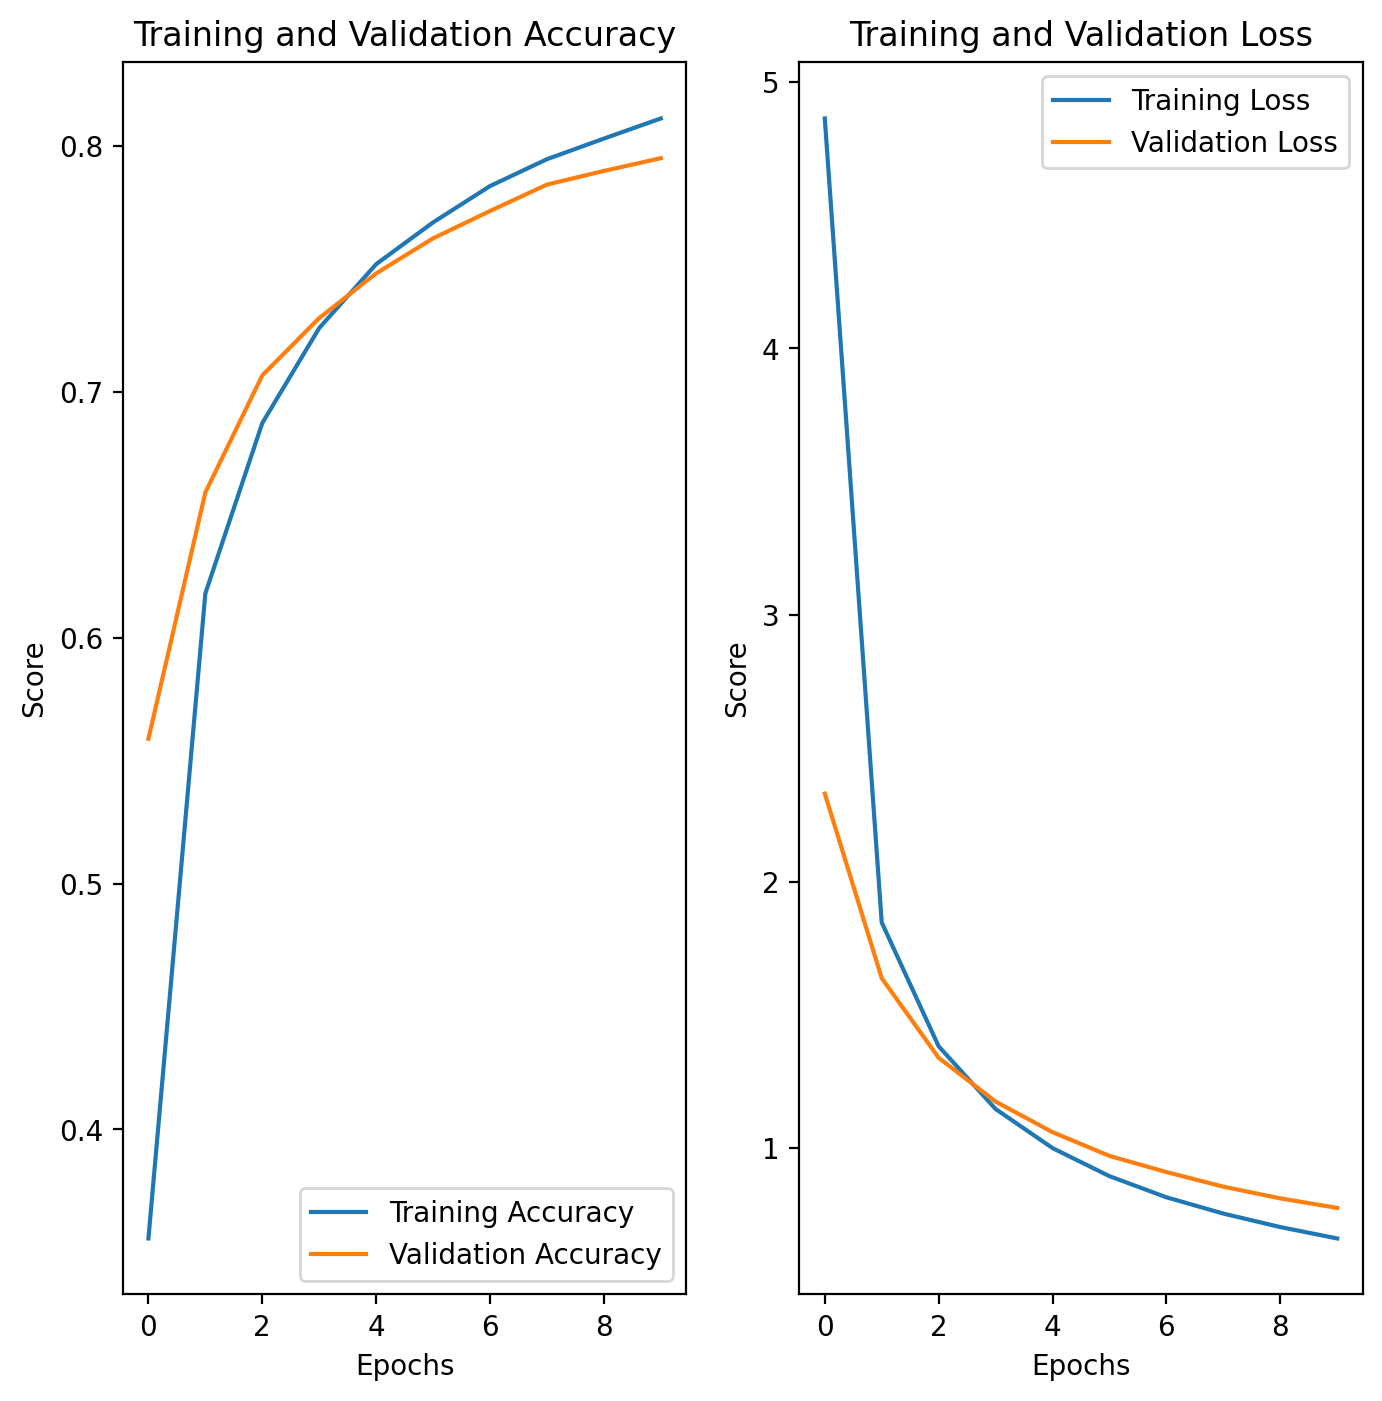

In [ ]:
# plotting the training and validation accuracy and loss

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace=2)

plt.plot(epochs_range, model.history.history["accuracy"], label="Training Accuracy")
plt.plot(
    epochs_range, model.history.history["val_accuracy"], label="Validation Accuracy"
)
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Accuracy ")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, model.history.history["loss"], label="Training Loss")
plt.plot(epochs_range, model.history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Loss ")
plt.show()


In [ ]:
print("Training accuracy: {:.2f}%".format((np.max(model.history.history['accuracy'])) * 100))

Training accuracy: 81.12%


In [ ]:
## fitting the model and training it with train dataset with 30 epochs and NADAM optimizer

with tf.device('/device:GPU:0'):
  model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=64)

Epoch 1/30
338/338 [==============================] - 25s 44ms/step - loss: 4.6996 - accuracy: 0.3450 - val_loss: 2.3395 - val_accuracy: 0.5517
Epoch 2/30
338/338 [==============================] - 13s 38ms/step - loss: 1.8460 - accuracy: 0.6227 - val_loss: 1.6258 - val_accuracy: 0.6548
Epoch 3/30
338/338 [==============================] - 13s 37ms/step - loss: 1.3797 - accuracy: 0.6906 - val_loss: 1.3109 - val_accuracy: 0.6978
Epoch 4/30
338/338 [==============================] - 13s 39ms/step - loss: 1.1431 - accuracy: 0.7285 - val_loss: 1.1378 - val_accuracy: 0.7278
Epoch 5/30
338/338 [==============================] - 13s 37ms/step - loss: 0.9965 - accuracy: 0.7496 - val_loss: 1.0136 - val_accuracy: 0.7459
Epoch 6/30
338/338 [==============================] - 13s 38ms/step - loss: 0.8902 - accuracy: 0.7668 - val_loss: 0.9328 - val_accuracy: 0.7550
Epoch 7/30
338/338 [==============================] - 14s 40ms/step - loss: 0.8130 - accuracy: 0.7819 - val_loss: 0.8679 - val_accuracy:

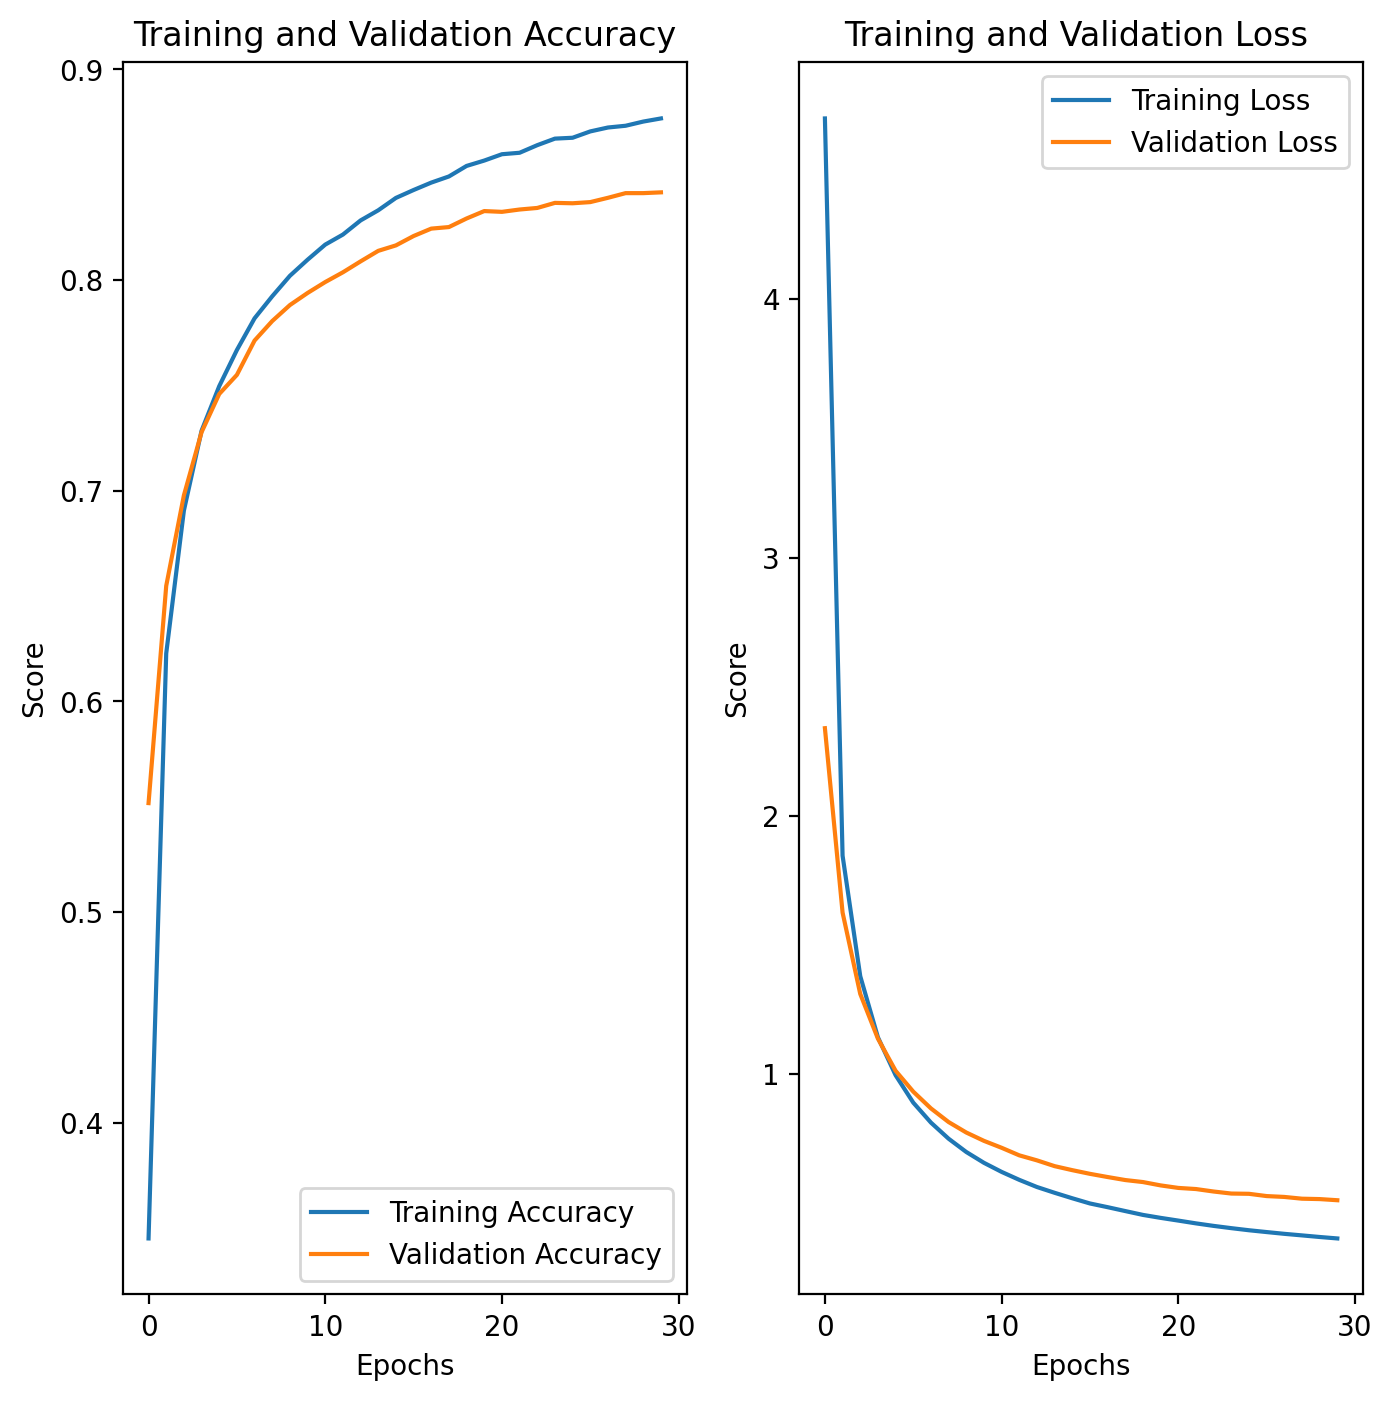

In [ ]:
# plotting the training and validation accuracy and loss

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace=2)

plt.plot(epochs_range, model.history.history["accuracy"], label="Training Accuracy")
plt.plot(
    epochs_range, model.history.history["val_accuracy"], label="Validation Accuracy"
)
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, model.history.history["loss"], label="Training Loss")
plt.plot(epochs_range, model.history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Loss ")
plt.show()

In [ ]:
print("Training accuracy: {:.2f}%".format((np.max(model.history.history['accuracy'])) * 100))

Training accuracy: 87.68%


In [ ]:
### testing the model on test_ds

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, batch_size=64)

# Print the test accuracy as a percentage
print('Test accuracy: {:.2f}%'.format(test_acc * 100))

422/422 [==============================] - 13s 31ms/step - loss: 0.3881 - accuracy: 0.8708
Test accuracy: 87.08%


In [ ]:
## adding some data augumentation as well to see improvements

In [ ]:
from tensorflow import keras
from keras.applications import DenseNet121 
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

base_model = DenseNet121(weights="imagenet", include_top=False) 

x = base_model.output
x = GlobalAveragePooling2D()(x)

data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ]
)

inputs = base_model.input 
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with softmax activation for classification
predictions = Dense(10, activation="softmax")(x)

# Create the model
model1 = Model(inputs=inputs, outputs=predictions)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Nadam(learning_rate=lr_schedule)

# Compile the model
model1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

## fitting the model and training it with train dataset 

# with tf.device('/device:GPU:0'):
model1.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=64)

In [ ]:
# plotting the training and validation accuracy and loss

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, model1.history.history["accuracy"], label="Training Accuracy")
plt.plot(
    epochs_range, model1.history.history["val_accuracy"], label="Validation Accuracy"
)
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, model1.history.history["loss"], label="Training Loss")
plt.plot(epochs_range, model1.history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training and Validation Loss")
plt.show()


In [ ]:
## resulted in an training accuracy of Training accuracy: 80.81% and Test accuracy: 75.16% and the graph was not better

In [ ]:
# creating a Testing directory
path = "/content/TrainedModel"
isExist = os.path.exists(path)
if not isExist:

    os.makedirs(path)
    print("The new directory is created!")

The new directory is created!


In [ ]:
## saving the trained model
torch.save(model, "/content/TrainedModel/densenet121_model.pth")

In [ ]:
##loading the trained model
trained_model = torch.load("/content/TrainedModel/densenet121_model.pth")

In [ ]:
test_data_directory = "/content/TestDataset/gridimages/imagesOP"

In [ ]:
## crops one of the LandSAT images and stores the tiles in imagesOP folder as Testing data
# creating a Testing directory
path = "/content/TestDataset/gridimages/onxard"
isExist = os.path.exists(path)
if not isExist:

    os.makedirs(path)
    print("The new directory is created!")

The new directory is created!


In [ ]:
def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = cv2.imread(os.path.join(dir_in, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = PIL.Image.fromarray(img)
    w, h = im_pil.size

    grid = itertools.product(range(0, h - h % d, d), range(0, w - w % d, d))
    for i, j in grid:
        box = (j, i, j + d, i + d)
        out = os.path.join(dir_out, f"{name}_{i}_{j}.PNG")
        im_pil.crop(box).save(out, quality=95)


tile(
    "city_004_color.TIFF",
    "/content/LandSAT_Extracted/LandSAT/oxnard",
    "/content/TestDataset/gridimages/onxard",
    64)

In [ ]:
test_data_directory = "/content/TestDataset/gridimages/onxard"

In [ ]:
import keras.utils as image_keras
# image folder
folder_path = test_data_directory

# dimensions of images
img_width, img_height = 64, 64


# load all images into a list
images = []
img_name = []
num_images = 0
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img_name.append(img)
    img = image_keras.load_img(img, target_size=(img_width, img_height))

    img = image_keras.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
    num_images += 1

# stack up images list to pass for prediction
images = np.vstack(images)
classes = trained_model.predict(images, batch_size=10)
predicted_classes =  np.argmax(classes, axis=1)

47/47 [==============================] - 11s 230ms/step


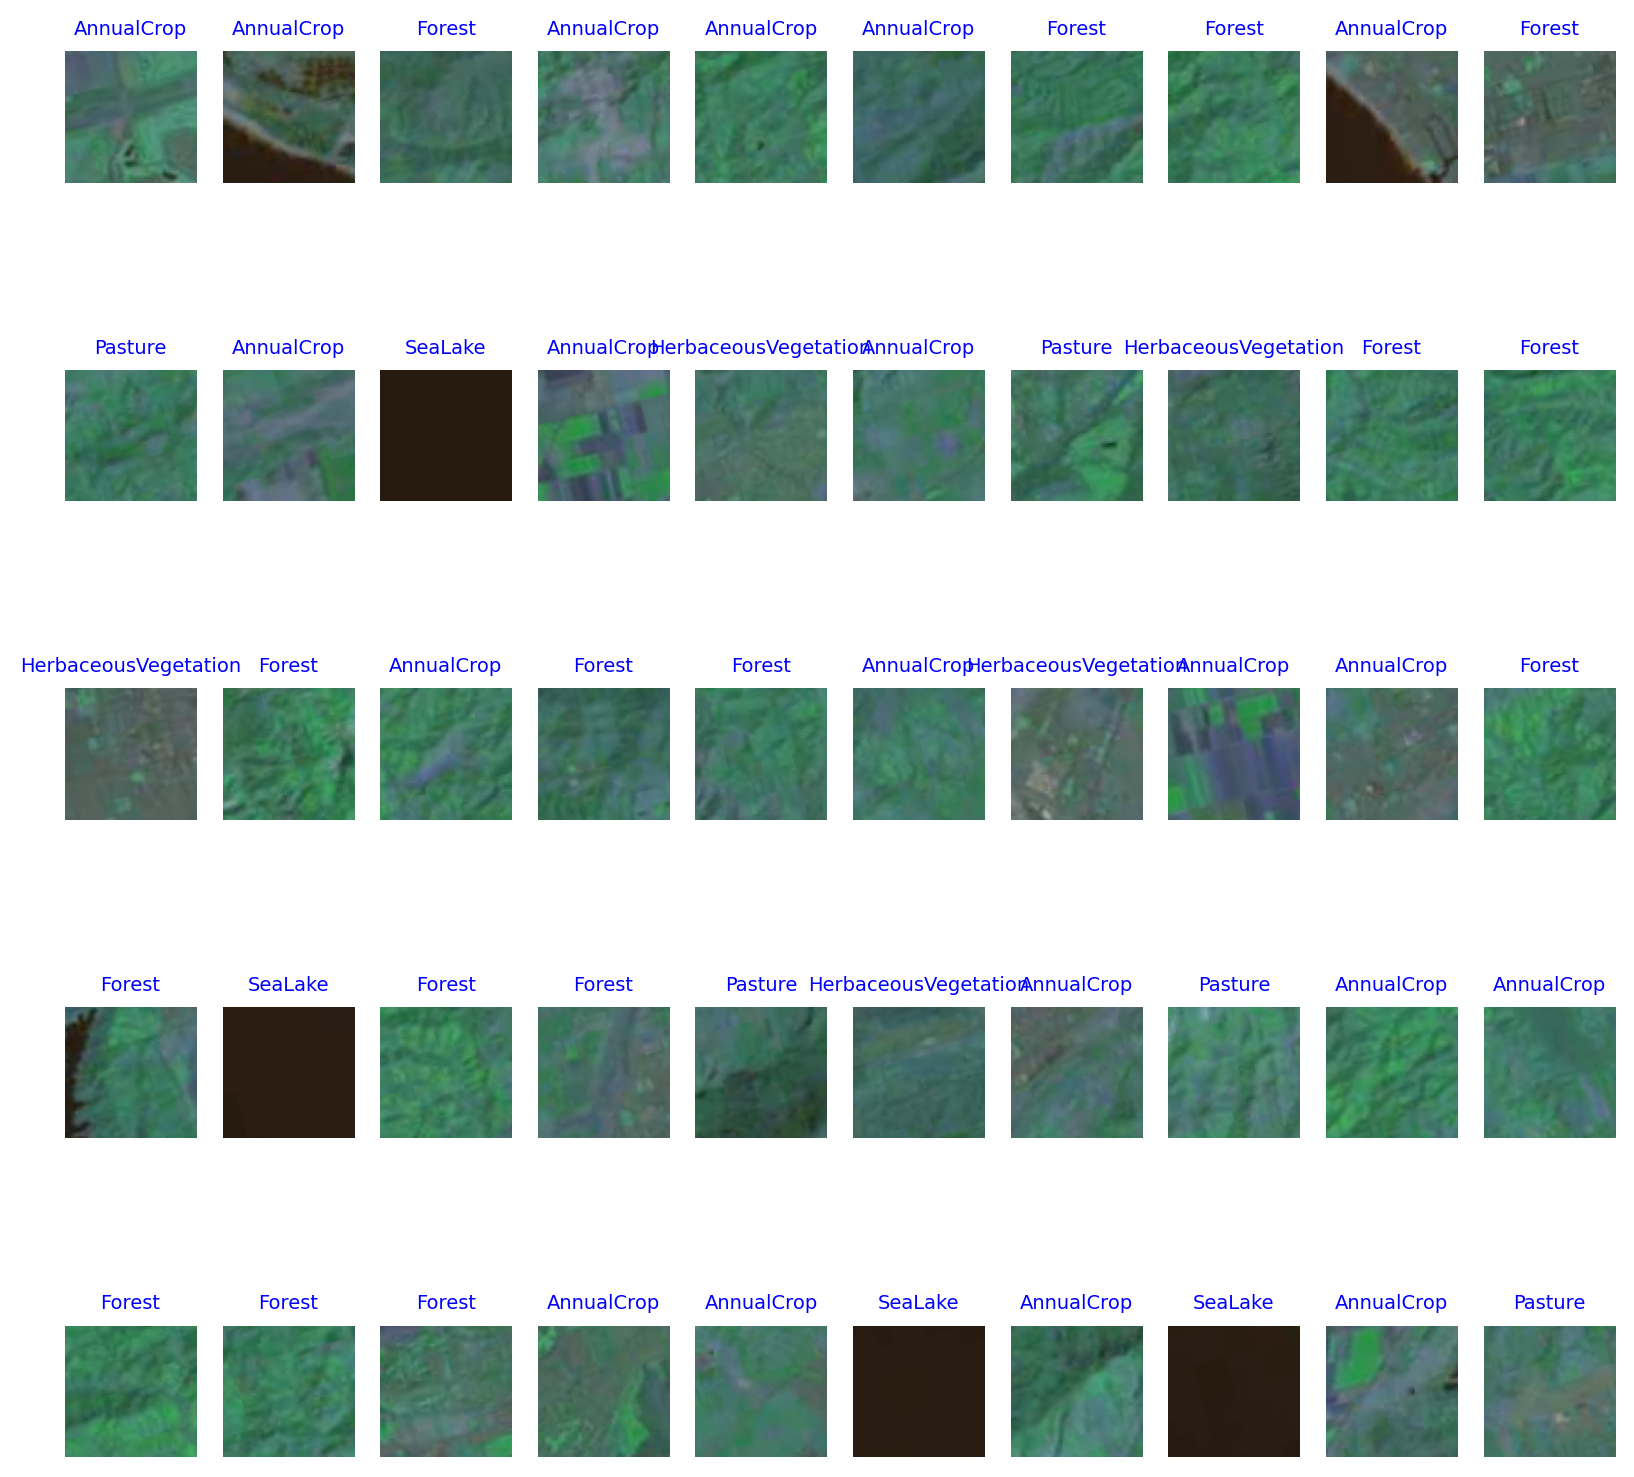

In [ ]:
classnames = trainingdata.class_names

# Show some examples of the predictions
plt.figure(figsize=(10,10))
for i in range(50):
    ax = plt.subplot(5,10, i + 1)
    final_img = cv2.imread(img_name[i])
    plt.imshow(final_img) 
    ax.set_title(classnames[predicted_classes[i]], color="blue", fontsize = 7) 
    plt.axis('off')
plt.show()